In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

DIR_TRAIN = os.getcwd() + "\\data\\train.csv"
DIR_TEST = os.getcwd() + "\\data\\test.csv"

test_names = ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
train_names = ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
               'Embarked']

In [35]:
def model():
    '''
    定义模型
    :return: keras model
    '''
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(32, activation='relu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2=0.001)))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(32, activation='relu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2=0.001)))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(16, activation='relu',kernel_regularizer=keras.regularizers.l1_l2(l1=0.001,l2=0.001)))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(1,activation='sigmoid'))
#     model.add(keras.layers.Dense(8, activation='relu'))
    model.compile(optimizer=keras.optimizers.RMSprop(), loss=keras.losses.binary_crossentropy, metrics=[keras.metrics.binary_accuracy])
    return model

In [36]:
keras_model = model()

In [4]:
def loadData(is_train, dir):
    if is_train:
        names = train_names
    else:
        names = test_names
    data = pd.read_csv(dir, header=0, names=names)
    return data

In [5]:
def progressData(data):
    # 补充完整数据
#     passengerId = data.pop('PassengerId')
    mean_age = round(data.mean()['Age'], 1)
    mean_fare = round(data.mean()['Fare'], 1)
    data = data.fillna({'Age': mean_age, 'Fare': mean_fare})
    data = data.fillna(method='ffill')
    return data

In [6]:
def splitData(datas, labels, splite):
    return train_test_split(datas, labels, test_size=splite, random_state=42)

In [7]:
def generator(data, lables, batch_size):
    idx = np.arange(len(data))
    print(len(data))
    np.random.shuffle(idx)
    print(data.columns)
    batchs = [idx[range(batch_size * i, min(len(data), batch_size * (i + 1)))] for i in
              range(int(len(data) / batch_size + 1))]
    while True:
        for i in batchs:
            xx = data.loc[i, :]
            yy = lables.loc[i]
            yield (xx, yy)

In [8]:
data_train = loadData(is_train=True, dir=DIR_TRAIN)

In [9]:
data_test = loadData(is_train=False,dir=DIR_TEST)

In [10]:
x_train = data_train.drop(['PassengerId','Name','Ticket','Survived','Cabin'],axis = 1)
y_train = data_train['Survived']

In [11]:
print(x_train.head())
print(y_train.head())

   Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0       3    male  22.0      1      0   7.2500        S
1       1  female  38.0      1      0  71.2833        C
2       3  female  26.0      0      0   7.9250        S
3       1  female  35.0      1      0  53.1000        S
4       3    male  35.0      0      0   8.0500        S
0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64


In [12]:
x_val = data_test.drop(['PassengerId','Name','Ticket','Cabin'],axis=1)

In [13]:
print('-' *10)
print(x_train.isnull().sum())
print('-' *10)
print(x_val.isnull().sum())

----------
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64
----------
Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64


In [14]:
print(x_train.shape)
print(x_val.shape)
data = x_train.append(x_val)
print(data.shape)

(891, 7)
(418, 7)
(1309, 7)


In [15]:
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


#### Age  Embarked  Fare 存在空数据

In [16]:
age_mean = data['Age'].mean()
fare_mean = data['Fare'].mean()
print('age mean : {}    fare mean : {}'.format(age_mean,fare_mean))

age mean : 29.881137667304014    fare mean : 33.2954792813456


In [17]:
data['Embarked'].mode()

0    S
dtype: object

In [18]:
data['Embarked'].fillna(data['Embarked'].mode()[0],inplace=True)
data = data.fillna({'Age':age_mean,'Fare':fare_mean})

In [19]:
print(data.isnull().sum())

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


#### 处理Sex Embarked 变为类别

In [20]:
data['Embarked'] = pd.Categorical(data['Embarked'])
data['Embarked'] = data['Embarked'].cat.codes+1

data['Sex'] = pd.Categorical(data['Sex'])
data['Sex'] = data['Sex'].cat.codes+1

In [21]:
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,2,22.0,1,0,7.2500,3
1,1,1,38.0,1,0,71.2833,1
2,3,1,26.0,0,0,7.9250,3
3,1,1,35.0,1,0,53.1000,3
4,3,2,35.0,0,0,8.0500,3


#### 将年龄和fare按区间分类

In [22]:
age_bin = [-1,0,5,12,18,25,35,60,120]
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
age_cat = pd.cut(data['Age'],bins=age_bin,labels=group_names)
data['Age'] = age_cat.cat.codes

In [23]:
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,2,4,1,0,7.2500,3
1,1,1,0,1,0,71.2833,1
2,3,1,7,0,0,7.9250,3
3,1,1,7,1,0,53.1000,3
4,3,2,7,0,0,8.0500,3


In [24]:
fare_bin = (-1, 0, 8, 15, 31, 1000)
group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
fare_cat = pd.cut(data['Fare'],bins=fare_bin,labels=group_names)
data['Fare'] = fare_cat.cat.codes
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,2,4,1,0,0,3
1,1,1,0,1,0,3,1
2,3,1,7,0,0,0,3
3,1,1,7,1,0,3,3
4,3,2,7,0,0,1,3


In [26]:
x_train = data.iloc[0:891]
x_val = data.iloc[891:]
x_train,x_test,y_train,y_test = splitData(x_train,y_train,0.2)

In [27]:
x_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
331,1,2,0,0,0,2,3
733,2,2,4,0,0,1,3
382,3,2,7,0,0,0,3
704,3,2,7,1,0,0,3
813,3,1,2,4,2,3,3


In [28]:
y_train = np.asarray(y_train)
x_train = np.asarray(x_train)

y_test = np.asarray(y_test)
y_train = np.asarray(y_train)

In [37]:
history = keras_model.fit(x_train,y_train,batch_size=128,validation_data=[x_test,y_test],epochs=50)

Train on 712 samples, validate on 179 samples
Epoch 1/50
712/712 [==============================] - 1s 1ms/step - loss: 1.0361 - binary_accuracy: 0.5281 - val_loss: 1.0002 - val_binary_accuracy: 0.5866
Epoch 2/50
712/712 [==============================] - 0s 21us/step - loss: 0.9787 - binary_accuracy: 0.6236 - val_loss: 0.9761 - val_binary_accuracy: 0.5866
Epoch 3/50
712/712 [==============================] - 0s 27us/step - loss: 0.9555 - binary_accuracy: 0.6292 - val_loss: 0.9593 - val_binary_accuracy: 0.5866
Epoch 4/50
712/712 [==============================] - 0s 25us/step - loss: 0.9375 - binary_accuracy: 0.6306 - val_loss: 0.9395 - val_binary_accuracy: 0.6034
Epoch 5/50
712/712 [==============================] - 0s 25us/step - loss: 0.9231 - binary_accuracy: 0.6433 - val_loss: 0.9243 - val_binary_accuracy: 0.6034
Epoch 6/50
712/712 [==============================] - 0s 24us/step - loss: 0.9097 - binary_accuracy: 0.6419 - val_loss: 0.9062 - val_binary_accuracy: 0.6089
Epoch 7/50
71

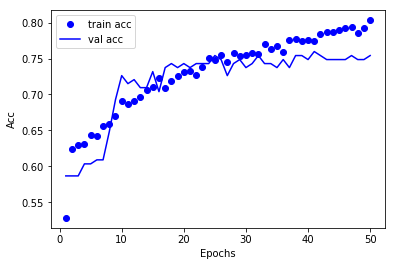

In [38]:
train_acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

epcho = range(1,len(train_acc)+1)

plt.plot(epcho,train_acc,'bo',label='train acc')
plt.plot(epcho,val_acc,'b',label='val acc')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

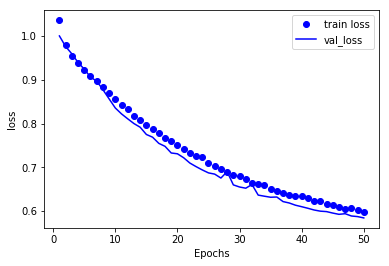

In [39]:
plt.clf()

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epcho = range(1,len(train_acc)+1)

plt.plot(epcho,train_loss,'bo',label='train loss')
plt.plot(epcho,val_loss,'b',label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()